# Analysis of the Experimental Results
Apply multivariate analysis of the experimental results

## Questions to investigate
For each of the clustering methods which one provides the best clustering of stations for the variants of epsilon nad maxPts. Best clustering can be defined as:
1. Most number of clusters with most number of stations (i.e. least noise)
1. Maximum quality measure with the silhouette coefficient, calinzki-harabaz score, davis-bouldin score, and dunn index

In [ ]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

### Get station data

___Note:___ You may skip retrieving data and running the prolonged clustering process and simply work analyze the quality measures from the ```results.csv``` file stored in the ```experiments``` folder.

In [1]:
''' Get all stations  '''
import sys
sys.path.insert(1, '../lib')
import stations

try:
    print('Please wait while we retrieve GeoNet station inventory data')
    cls_st = stations.station_data()
    __client = cls_st.get_client()
    st_list, invalid_st_list, _ = cls_st.get_stations(__client)
    if not st_list:
        raise TypeError

    print(f'In the inventory of {len(st_list)+len(invalid_st_list)} total station')
    print(f'There are {len(st_list)} active stations inside the main geographic land boundaries.')
    print(f'and {len(invalid_st_list)} active stations outside the main geographic land boundaries.')
    print('Complete')

except Exception as err:
    print("Error message:", err)    

Please wait while we retrieve GeoNet station inventory data


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


In the inventory of 454 total station
There are 451 active stations inside the main geographic land boundaries.
and 3 active stations outside the main geographic land boundaries.
Complete


In [2]:
import pandas as pd

''' Define the list of station types to filter the station inventory data '''
__lst_st_type_80Hz_above = ['EH']
lst_st_80Hz_above = [[st_name,st_type, st_lat,st_lon]
                          for st_name,st_type,st_lat,st_lon in st_list 
                          if st_type in __lst_st_type_80Hz_above]
station_df = pd.DataFrame(lst_st_80Hz_above, columns=['st_name','st_type','st_lat','st_lon'])

''' Initialize label column as -1 indicating individual stations to be noise to begin with '''
l_label = [-1]*station_df.shape[0]
station_df['label'] = -1
station_df.set_index(['st_type','label'])

print('%d stations of type %s are ready for clustering' % (station_df.shape[0],__lst_st_type_80Hz_above))

116 stations of type ['EH'] are ready for clustering


### Get clustering sequence parameters

In [17]:
''' Get clustering experiment sequence parameters from the spreadsheet '''
import pandas as pd
import sys; sys.path.insert(1, '../lib')
import cluster_quality as cq
import graph_clustering as gc
import importlib
cq = importlib.reload(cq)
gc = importlib.reload(gc)

import sys
import time
import traceback

#seq_input_file = "./cluster_runs.csv"
#results_file = "./results.csv"
seq_input_file = "./cluster_runs_cloud.csv"
results_file = "./results_cloud.csv"
''' Load data from CSV '''
#_iter_combos_df = pd.read_csv("../experiments/cluster_runs.csv")
_exp_seq_df = pd.read_csv(seq_input_file)
#exp_seq = 9
clust_quality = cq.cluster_quality_metric()
results_df_ = pd.DataFrame([])     # dataframe to store the results

print('Start clustering and acqur quality parameters for %d sequences' % _exp_seq_df.shape[0])
for exp_seq in range(_exp_seq_df.shape[0]):
    s_clust_cls_, s_clust_name_, dict_params_ = clust_quality.get_seq_params(_exp_seq_df, exp_seq)
    st_clust_df_ = pd.DataFrame([])     # dataframe for the stations and cluster labels
    st_clust_df_ = clust_quality.get_clusters(dict_params_,
                                              station_df,
                                              s_clust_cls_,
                                              s_clust_name_)
    _n_clusters = len(st_clust_df_['label'].unique())

    if _n_clusters > 1:
        clust_quality.set_quality_frame(clustering_name=s_clust_name_, **dict_params_)
        results_df_=results_df_.append(clust_quality.get_quality_metrics(st_clust_df_))

    else:
        print('No results were added for %s; cannot compute quality metric for %d clusters\n'
              % (s_clust_name_, _n_clusters))

if results_df_.shape[0] > 0:
    l_seq = list(range(0,(results_df_.shape[0])))
    results_df_.insert(0, 'Sequence', l_seq)
    results_df_.set_index('Sequence')
    results_df_.to_csv(results_file, index=False)
    
print('Quality metric results for %d clustering sequences are stored in %s' 
      % (exp_seq+1,results_file))

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that res

Quality metric results for 160 clustering sequences are stored in ./results_cloud.csv


## Prepare and Enrich Quality Metrics

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

results_file = "./results.csv"
_results_df=pd.read_csv(results_file)
#_results_df.head()
lst_drop_cols = ['Sequence', 'Station Types', 'Station Quantity', 'Metric']
_results_df = _results_df.drop(lst_drop_cols,axis=1)

lst_norm_cols = list(["Silhouette Coefficient","Calinski Harabaz score","Davies Bouldin score",
                      "Dunn Index","Modularity","Conductance Average","Coverage Score","Performance Score"])
_results_df[lst_norm_cols] = _results_df[lst_norm_cols].apply(pd.to_numeric)
''' append algorithm and method to name '''
_results_df['Cluster Sequence'] = (_results_df['Name']+' '+_results_df['Algorithm']+
                                   ' '+_results_df['Method']+' '+_results_df['Seed'])
#_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].map(lambda x: x.rstrip('-None'))
#_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.rstrip("None")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace("None","")
_results_df['Cluster Sequence'] = _results_df['Cluster Sequence'].str.replace("   ","-")
_results_df.info()
print(_results_df['Cluster Sequence'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Maximum Distance         280 non-null    int64  
 1   Minimum Points           280 non-null    int64  
 2   Name                     280 non-null    object 
 3   Algorithm                280 non-null    object 
 4   Method                   280 non-null    object 
 5   Seed                     280 non-null    object 
 6   Generated Cluster Count  280 non-null    int64  
 7   Valid Cluster Count      280 non-null    int64  
 8   Clustered Station Count  280 non-null    int64  
 9   Unclsutered Noise Count  280 non-null    int64  
 10  Average Node Degree      280 non-null    float64
 11  Silhouette Coefficient   280 non-null    float64
 12  Calinski Harabaz score   280 non-null    float64
 13  Davies Bouldin score     280 non-null    float64
 14  Dunn Index               2

### Normalize quality measures

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

_norm_df = _results_df.copy()
#lst_norm_cols = list(['Silhouette Coefficient',
#                      'Calinski Harabaz score',
#                      'Davies Bouldin score',
#                      'Dunn Index'])
for col in lst_norm_cols:
    scaled = scaler.fit_transform(np.array(_norm_df[col]).reshape(-1,1))
    _norm_df[col] = pd.DataFrame(scaled)
_norm_df = _norm_df.dropna()
print('Normalization complete!')

Normalization complete!


### Correlation matrix
We [plot the correlation matrix](https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e) to determine if there is a single cluster quality measure we could use to analyze the clusters for each combination of clustering method, epsilon, and minPts.
* Calinski Harabaz score is positively correlated with Silhouette coefficient and the Dunn Index but negatively correlated with Davies Bouldin score; therefore, we can eliminate the Calinski Harabaz score
* However, the Silhouette coefficient, Davies Bouldin score and the Dunn Index are negatively correlated with each other
* The Silhouette coefficient and the Davies Bouldin score are closer to 0 implying we may select on of them as the quality measure.
* The **Davies Bouldin score** is furthest away from the Dunn Index and the Calinski Harabaz score, which implies it would it be the preffered choice to select as the single cluster qulity indicator.

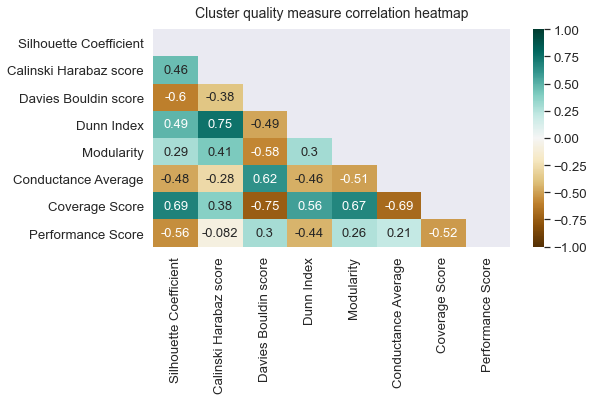

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

_corr_plt_df = _norm_df[lst_norm_cols]
plt.figure(figsize=(8,4))
mask = np.triu(np.ones_like(_corr_plt_df.corr(), dtype=np.bool))

sns.set(font_scale=1.2)
heatmap = sns.heatmap(_corr_plt_df.corr(), mask=mask,
                      vmin=-1,vmax=1,annot=True,annot_kws={"size": 13},cmap='BrBG')
heatmap.set_title('Cluster quality measure correlation heatmap',fontdict={'fontsize':14}, pad=12)
plt.savefig('../images/outputs/cluster_quality_measure_correlation_heatmap.png', bbox_inches='tight')
plt.show()

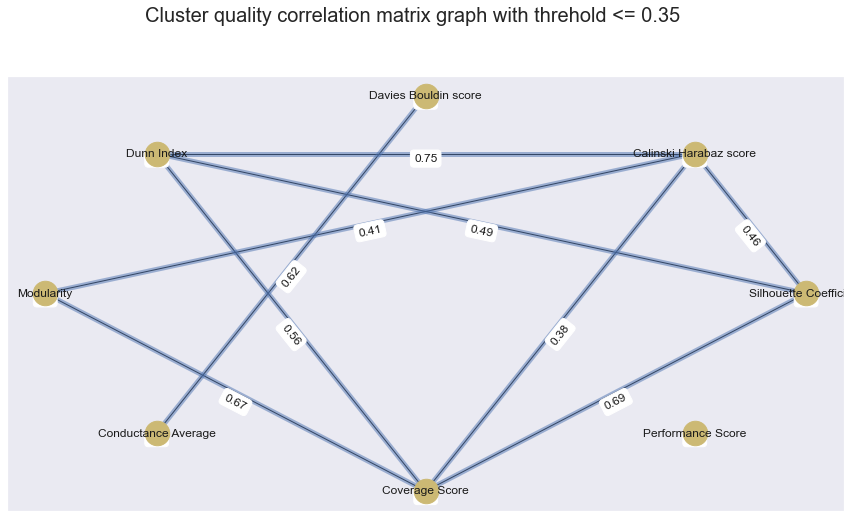

In [16]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

''' set the correlation threshold in the iterval of [-1.0,1.0] it relates to the 
    edge-weights and those edges to remove from the correlation matrix graph '''
_f_corr_thresh = 0.35
''' True: removes all edges => _f_corr_thresh (i.e. to leave edges with correlations < _f_corr_thresh)
    False: removes all edges <= _f_corr_thresh (i.e. to leave edges with correlations < _f_corr_thresh)'''
_remove_gt = False

''' Construct the correlation matrix graph '''
df_corr = _corr_plt_df.corr().round(2)
G = nx.from_pandas_adjacency(df_corr)
edge_weights = nx.get_edge_attributes(G,'weight')
if _remove_gt:
    G.remove_edges_from((e for e, w in edge_weights.items() if w > _f_corr_thresh))
    s_title = "Cluster quality correlation matrix graph with threhold => %0.02f" % _f_corr_thresh
else:
    G.remove_edges_from((e for e, w in edge_weights.items() if w < _f_corr_thresh))
    s_title = "Cluster quality correlation matrix graph with threhold <= %0.02f" % _f_corr_thresh
G.name = "Correlation Matrix Graph"

''' Plot the graph with edges representing the correlation '''
plt.figure(figsize=(15,8))
node_pos = pos=nx.circular_layout(G)
#print(node_pos)
nx.draw_networkx(G, node_pos,node_size=600, node_color="y", node_shape='o')
nx.draw_networkx_edges(G, node_pos, width=5.0, alpha=0.5,edge_color="b")
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, node_pos,
                             edge_labels=edge_labels, label_pos=0.5,
                             font_size=12, font_family="Arial",
                             horizontalalignment='center', verticalalignment='top')
#nx.draw(G)
plt.suptitle(s_title,y=1.0, size=20)
plt.grid(False)
plt.savefig('../images/outputs/cluster_quality_measure_correlation_graph.png', bbox_inches='tight')
plt.show()

### Chi-sqaure Test

In [22]:
from scipy.stats import normaltest, ansari, chisquare, chi2, chi2_contingency
import numpy as np

_hypo_test_df = _norm_df.copy()

for p_mesr_idx, p_mesr_name in enumerate(lst_norm_cols):
    p_mesr_arr = _hypo_test_df[p_mesr_name].to_numpy()
    s_norm = ""
    s_chisqr = ""
    norm_stat, norm_p = normaltest(p_mesr_arr)
    chisqr_sta, chisqr_p = chisquare(p_mesr_arr)

    if norm_p < 0.05:
        s_norm = '[Normal distribution]'
    if chisqr_p < 0.05:
        s_chisqr = "[Chisquare]"
    print('%s Mean = %0.04f & Variance = %0.04f %s %s' 
          % (p_mesr_name, np.mean(p_mesr_arr), np.var(p_mesr_arr), s_norm, s_chisqr))
    
    for s_mesr_idx, s_mesr_name in enumerate(lst_norm_cols):
        if s_mesr_idx > p_mesr_idx:
            validity_data = np.array([_hypo_test_df[p_mesr_name],_hypo_test_df[s_mesr_name]])
#            chi_stat, chi_p, chi_dof, expected = chi2_contingency(validity_data,correction=False)
#            print(validity_data[0],validity_data[1])
            ans_stat, ans_p = ansari(validity_data[0],validity_data[1])
#            print('H0: %s is different from %s stat: %0.04f p-value: %0.04f dof: %0.04f' 
#                  % (p_mesr_name,s_mesr_name, stat, p, dof))
            if ans_p < 0.05:
                print('Different from %s with p-value: %0.04f' % (s_mesr_name, ans_p))
            else:
                print('Same as %s with p-value: %0.04f' % (s_mesr_name, ans_p))
    print()

Silhouette Coefficient Mean = 0.4775 & Variance = 0.0623 [Normal distribution] 
Same as Calinski Harabaz score with p-value: 0.1534
Same as Davies Bouldin score with p-value: 0.0931
Different from Dunn Index with p-value: 0.0000
Different from Modularity with p-value: 0.0000
Different from Conductance Average with p-value: 0.0000
Different from Coverage Score with p-value: 0.0000
Different from Performance Score with p-value: 0.0000

Calinski Harabaz score Mean = 0.0735 & Variance = 0.0237 [Normal distribution] 
Different from Davies Bouldin score with p-value: 0.0000
Different from Dunn Index with p-value: 0.0008
Same as Modularity with p-value: 0.6042
Different from Conductance Average with p-value: 0.0000
Different from Coverage Score with p-value: 0.0000
Same as Performance Score with p-value: 0.4149

Davies Bouldin score Mean = 0.0939 & Variance = 0.0112 [Normal distribution] 
Different from Dunn Index with p-value: 0.0000
Same as Modularity with p-value: 0.5278
Different from Con

### Plot quality measures

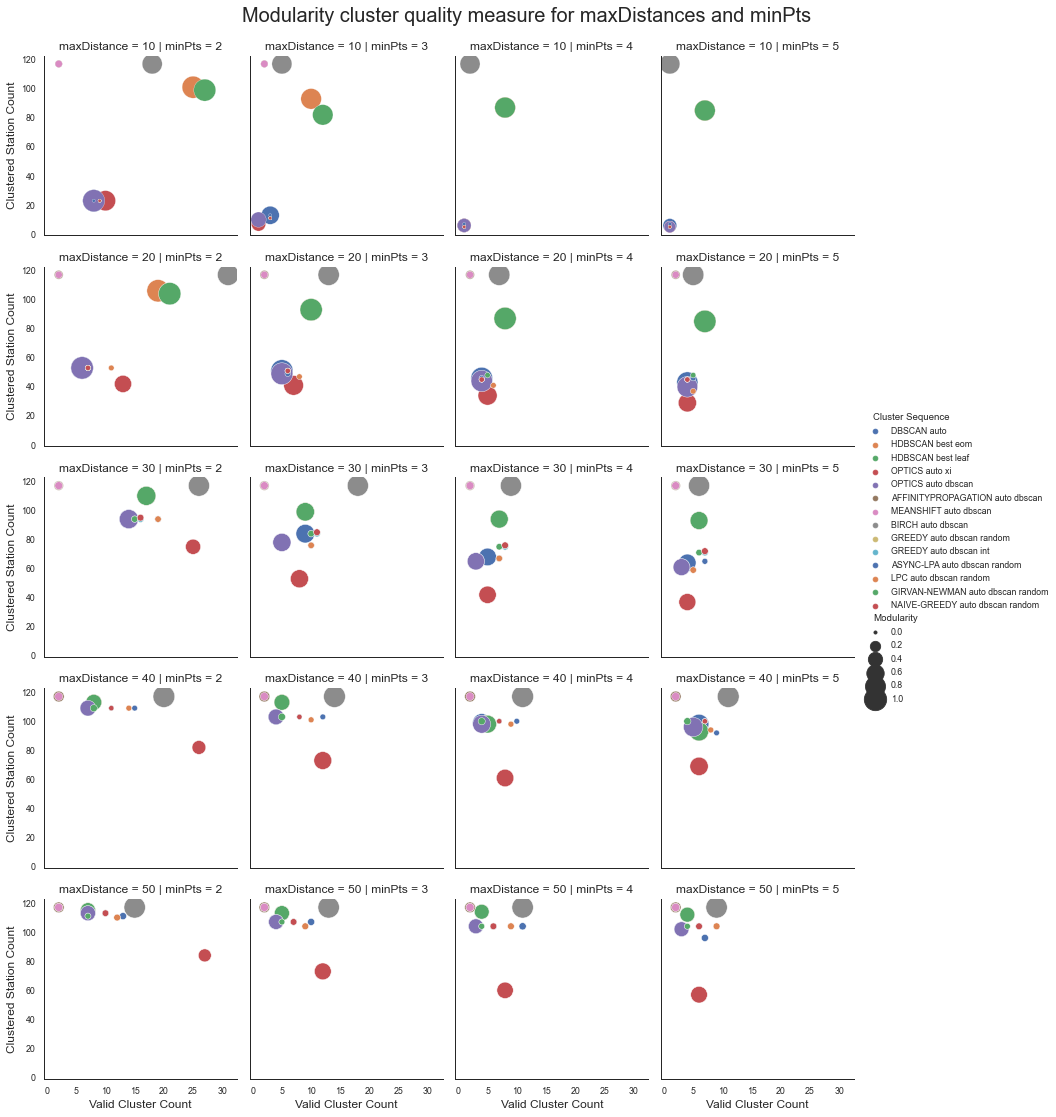

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

''' @parameter
    use any of the quality measures to view a plot of the cluster sizes and number of stations clustered
    _s_size = {"Silhouette Coefficient","Calinski Harabaz score","Davies Bouldin score","Dunn Index",
            "Modularity","Conductance Average","Coverage Score","Performance Score"])
'''
_s_size = "Modularity"

''' Copy the dataframe of normalized quality measures '''
_plot_df = _norm_df.copy()
_plot_df=_plot_df.rename(columns={"Maximum Distance": "maxDistance", "Minimum Points": "minPts"})
#plot_qlty_msr_df=[cloud_norm_df['Method','Cluster Count','Clustered Station Count',
#                          'Minimum Points','Distance','Davies Bouldin score']]
#plt.figure(figsize=(5,5))
plt.rcParams['figure.figsize']=(10,10)
#fig, g = plt.subplots(2, 2, figsize=(15,2*5), dpi=100, sharex=True, sharey=True)
sns.set_style("white")
sns.set_context("paper", 
                rc={"font.size":12, "axes.labelsize":12}, 
                font_scale=1.0)
g=sns.relplot(
    data=_plot_df,
    row='maxDistance', col='minPts',
    x="Valid Cluster Count", y="Clustered Station Count",
    hue="Cluster Sequence", size=_s_size,
    palette='deep', sizes=(10, 500),
    height=3.0
    #facet_kws={'sharey': True, 'sharex': True} --- doesn't work
)

plt.suptitle(_s_size+" cluster quality measure for maxDistances and minPts",y=1.02, size=20)
#g.fig.legend(markerscale=1.2)

_s_plot_save_file = str("../images/outputs/relplot "+_s_size+".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')
#plt.savefig('../images/outputs/cluster_relational_plot.png', bbox_inches='tight')
plt.show()

## Redundant Code

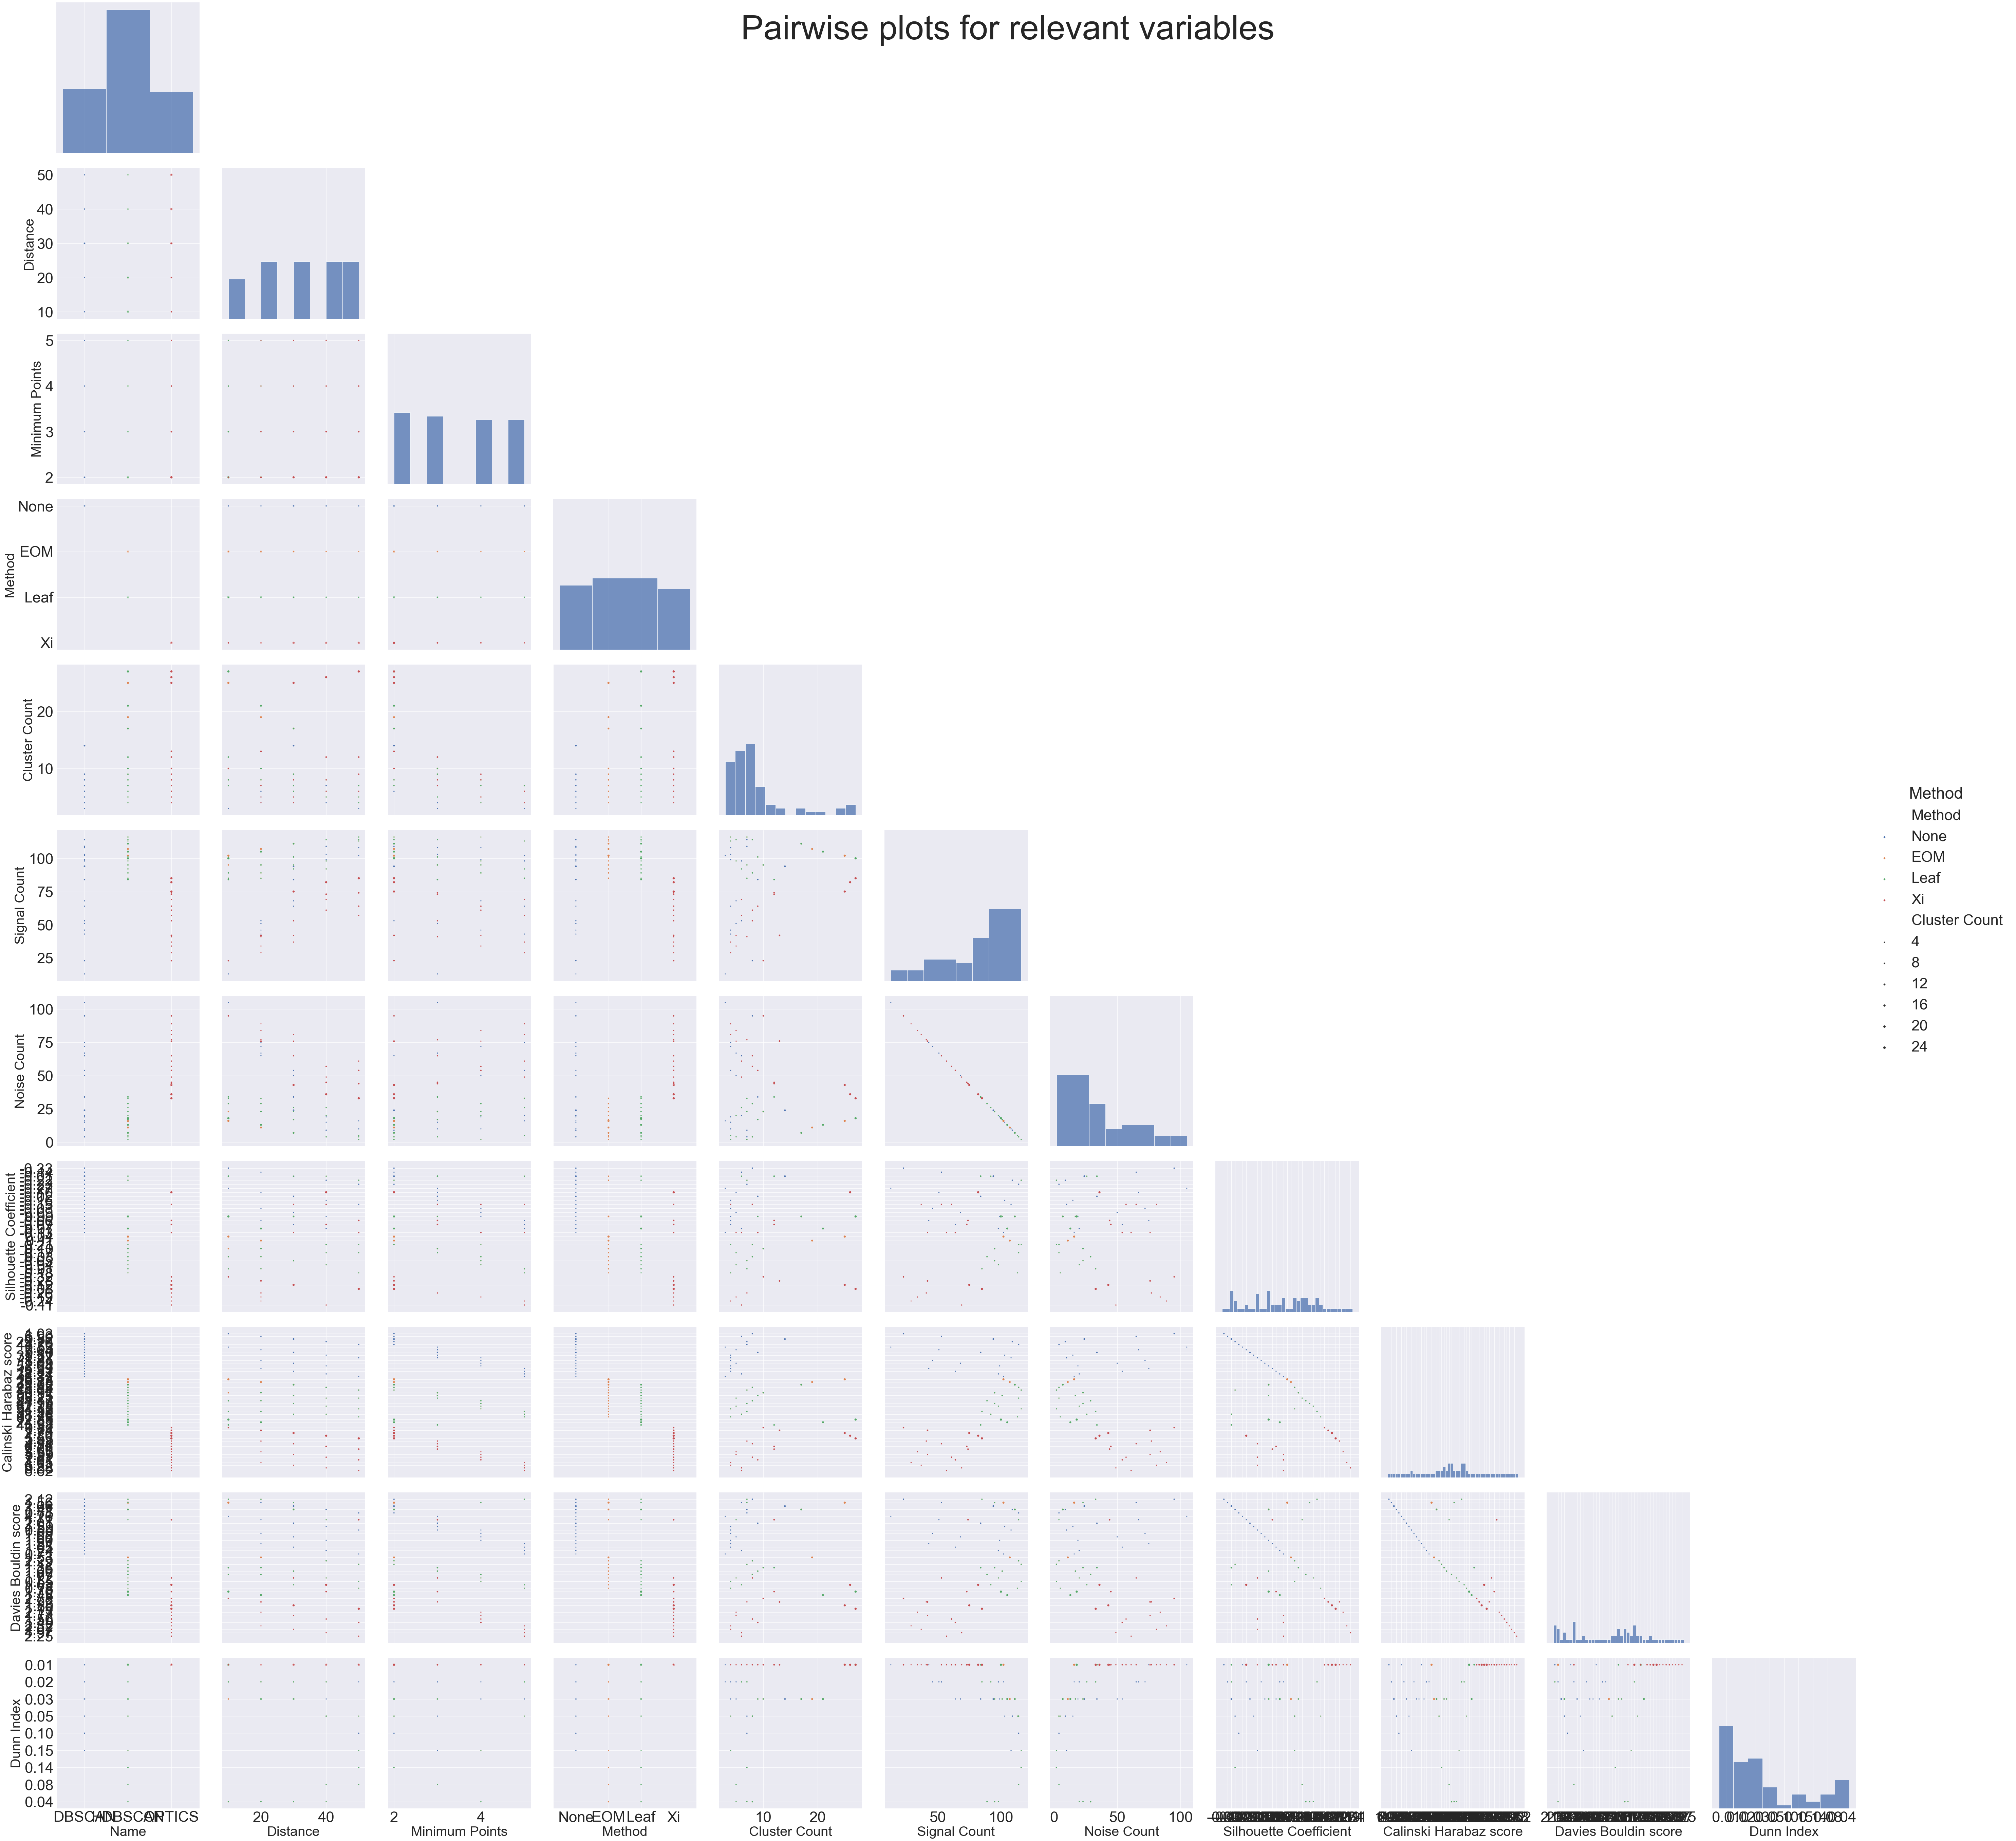

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pg_plot_df = cloud_clust_df.copy()
lst_vars = list(pg_plot_df.columns)
#lst_vars = list([''])
#x_vars=[cloud_clust_df['Distance'],cloud_clust_df['Minimum Points'],
#        cloud_clust_df['Cluster Count'],cloud_clust_df['Signal Count'],
#        cloud_clust_df['Noise Count']]
#y_vars=[cloud_clust_df['Silhouette Coefficient'],cloud_clust_df['Calinski Harabaz score'],
#        cloud_clust_df['Davies Bouldin score'],cloud_clust_df['Dunn Index']]
sns.color_palette("husl", 4)
sns.set_context("paper", rc={"font.size":8, "axes.labelsize":40}, font_scale=5)
''' kind = hist, scatter, '''
#g = sns.PairGrid(cloud_clust_df, hue='Method_Code', corner=True,hue_order=None,
#                 kind='scatter', diag_kind='hist', height=7,markers='o',
#                 plot_kws={"s": 200}, color=".3")
g = sns.PairGrid(pg_plot_df, hue="Method", vars=lst_vars, corner=True, height=7)
g.map_diag(sns.histplot, hue=None)
#g.map_upper(sns.scatterplot)
#g.map_lower(sns.kdeplot)
g.map_offdiag(sns.scatterplot,s=200, size=pg_plot_df["Cluster Count"])
g.fig.suptitle("Pairwise plots for relevant variables", size=100) # y= some height > 1
g.add_legend()
#g.fig.legend(markerscale=2)
plt.show()

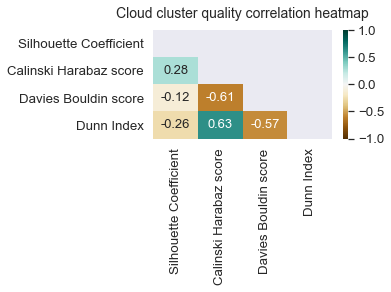

In [64]:
'''DEPRECATE graph and cloud clustering metrics have been combined'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cloud_corr_plt_df = cloud_norm_df[lst_norm_cols]
plt.figure(figsize=(4,2))
mask = np.triu(np.ones_like(cloud_corr_plt_df.corr(), dtype=np.bool))

sns.set(font_scale=1.2)
heatmap = sns.heatmap(cloud_corr_plt_df.corr(), mask=mask,vmin=-1, vmax=1,annot=True,annot_kws={"size": 13},cmap='BrBG')
heatmap.set_title('Cloud cluster quality correlation heatmap',fontdict={'fontsize':14}, pad=12)
plt.savefig('../images/outputs/cloud_cluster_quality_correlation_heatmap.png', bbox_inches='tight')
plt.show()

In [97]:
graph_hypo_test_df = graph_norm_df.copy()

for p_mesr_idx, p_mesr_name in enumerate(g_lst_norm_cols):
    p_mesr_arr = graph_hypo_test_df[p_mesr_name].to_numpy()
    s_norm = ""
    norm_stat, norm_p = normaltest(p_mesr_arr)
    if norm_p < 0.05:
        s_norm = '[Normal distribution]'
    print('%s Mean = %0.04f & Variance = %0.04f %s' 
          % (p_mesr_name, np.mean(p_mesr_arr), np.var(p_mesr_arr), s_norm))
    
    for s_mesr_idx, s_mesr_name in enumerate(g_lst_norm_cols):
        if s_mesr_idx > p_mesr_idx:
            validity_data = np.array([graph_hypo_test_df[p_mesr_name],graph_hypo_test_df[s_mesr_name]])
            stat, p, dof, expected = chi2_contingency(validity_data)
            a_stat, a_p = ansari(validity_data[0],validity_data[1])
            if a_p < 0.05:
                print('Different: %s from %s with p-value: %0.04f' % (p_mesr_name,s_mesr_name, a_p))
            else:
                print('Same: %s as %s with p-value: %0.04f' % (p_mesr_name,s_mesr_name, a_p))
    print()

Modularity Mean = 0.5013 & Variance = 0.0841 [Normal distribution]
Different: Modularity from Conductance Average with p-value: 0.0228
Different: Modularity from Coverage Score with p-value: 0.0012
Same: Modularity as Performance Score with p-value: 0.7574

Conductance Average Mean = 0.3638 & Variance = 0.0608 
Same: Conductance Average as Coverage Score with p-value: 0.1042
Same: Conductance Average as Performance Score with p-value: 0.4053

Coverage Score Mean = 0.6617 & Variance = 0.0421 [Normal distribution]
Different: Coverage Score from Performance Score with p-value: 0.0011

Performance Score Mean = 0.6435 & Variance = 0.0779 [Normal distribution]



In [21]:
''' DEPRECATED since cloud and graph clustering is combined now'''

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

cloud_clust_df=pd.read_csv("../experiments/Experiment_Data_Cloud_Cluster.csv")
#cloud_clust_df.head()
lst_drop_cols = ['Trial', 'Station Type', 'Station Quantity', 'Algorithm', 
               'Epsilon', 'Metric', 'Fit_Predict']
cloud_clust_df = cloud_clust_df.drop(lst_drop_cols,axis=1)
cloud_clust_df = cloud_clust_df[~cloud_clust_df["Silhouette Coefficient"].isin(['None'])]
cloud_clust_df = cloud_clust_df[~cloud_clust_df["Calinski Harabaz score"].isin(['None'])]
cloud_clust_df = cloud_clust_df[~cloud_clust_df["Davies Bouldin score"].isin(['None'])]
cloud_clust_df = cloud_clust_df[~cloud_clust_df["Dunn Index"].isin(['None'])]

lst_norm_cols = list(['Silhouette Coefficient',
                      'Calinski Harabaz score',
                      'Davies Bouldin score',
                      'Dunn Index'])
cloud_clust_df = cloud_clust_df.astype({'Silhouette Coefficient': 'float64'})
cloud_clust_df = cloud_clust_df.astype({'Calinski Harabaz score': 'float64'})
cloud_clust_df = cloud_clust_df.astype({'Davies Bouldin score': 'float64'})
cloud_clust_df = cloud_clust_df.astype({'Dunn Index': 'float64'})

''' append cluster name to method '''
#cloud_clust_df['Method'] = cloud_clust_df['Name']+'-'+cloud_clust_df['Method']
cloud_clust_df.loc[cloud_clust_df['Method'] != 'None','Name'] = cloud_clust_df['Name']+'-'+cloud_clust_df['Method']
cloud_clust_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 79
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     75 non-null     object 
 1   Distance                 75 non-null     float64
 2   Minimum Points           75 non-null     int64  
 3   Method                   75 non-null     object 
 4   Cluster Count            75 non-null     int64  
 5   Clustered Station Count  75 non-null     int64  
 6   Unclsutered Noise Count  75 non-null     int64  
 7   Silhouette Coefficient   75 non-null     float64
 8   Calinski Harabaz score   75 non-null     float64
 9   Davies Bouldin score     75 non-null     float64
 10  Dunn Index               75 non-null     float64
dtypes: float64(5), int64(4), object(2)
memory usage: 9.5+ KB


In [72]:
''' DEPRECATE both classes combined '''
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

graph_clust_df=pd.read_csv("../results/Experiment_Data_Graph_Cluster.csv")
#graph_clust_df.head()
lst_drop_cols = ['Trial', 'Station Type', 'Station Quantity', 'Algorithm', 
               'Epsilon', 'Metric', 'Fit_Predict']
graph_clust_df = graph_clust_df.drop(lst_drop_cols,axis=1)
graph_clust_df = graph_clust_df[~graph_clust_df["Modularity"].isin(['None'])]
graph_clust_df = graph_clust_df[~graph_clust_df["Conductance Average"].isin(['None'])]
graph_clust_df = graph_clust_df[~graph_clust_df["Coverage Score"].isin(['None'])]
graph_clust_df = graph_clust_df[~graph_clust_df["Performance Score"].isin(['None'])]

''' append cluster name to method '''
#graph_clust_df['Name'] = graph_clust_df['Name']+'-'+graph_clust_df['Method']
#graph_clust_df.loc[graph_clust_df['Method'] == 'None','Name'] = graph_clust_df['Name']
graph_clust_df.loc[graph_clust_df['Method'] != 'None','Name'] = graph_clust_df['Name']+'-'+graph_clust_df['Method']
graph_clust_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     100 non-null    object 
 1   Distance                 100 non-null    float64
 2   Minimum Points           100 non-null    int64  
 3   Method                   100 non-null    object 
 4   Cluster Count            100 non-null    int64  
 5   Clustered Station Count  100 non-null    int64  
 6   Unclsutered Noise Count  100 non-null    int64  
 7   Modularity               100 non-null    float64
 8   Conductance Average      100 non-null    float64
 9   Coverage Score           100 non-null    float64
 10  Performance Score        100 non-null    float64
dtypes: float64(5), int64(4), object(2)
memory usage: 14.4+ KB


In [73]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

graph_norm_df = graph_clust_df.copy()
g_lst_norm_cols = list(['Modularity',
                      'Conductance Average',
                      'Coverage Score',
                      'Performance Score'])
for col in g_lst_norm_cols:
    scaled = scaler.fit_transform(np.array(graph_clust_df[col]).reshape(-1,1))
    graph_norm_df[col] = pd.DataFrame(scaled)
graph_norm_df = graph_norm_df.dropna()
print('Normalization complete!')

Normalization complete!


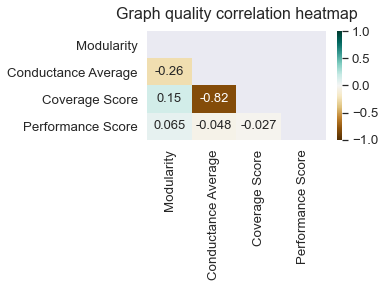

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

graph_corr_plt_df = graph_norm_df[g_lst_norm_cols]
plt.figure(figsize=(4,2))
mask = np.triu(np.ones_like(graph_corr_plt_df.corr(), dtype=np.bool))

sns.set(font_scale=1.2)
heatmap = sns.heatmap(graph_corr_plt_df.corr(), mask=mask,vmin=-1, vmax=1,annot=True,annot_kws={"size": 13}, cmap='BrBG')
heatmap.set_title('Graph quality correlation heatmap',fontdict={'fontsize':16}, pad=12)
plt.savefig('../images/outputs/graph_cluster_quality_correlation_heatmap.png', bbox_inches='tight')
plt.show()

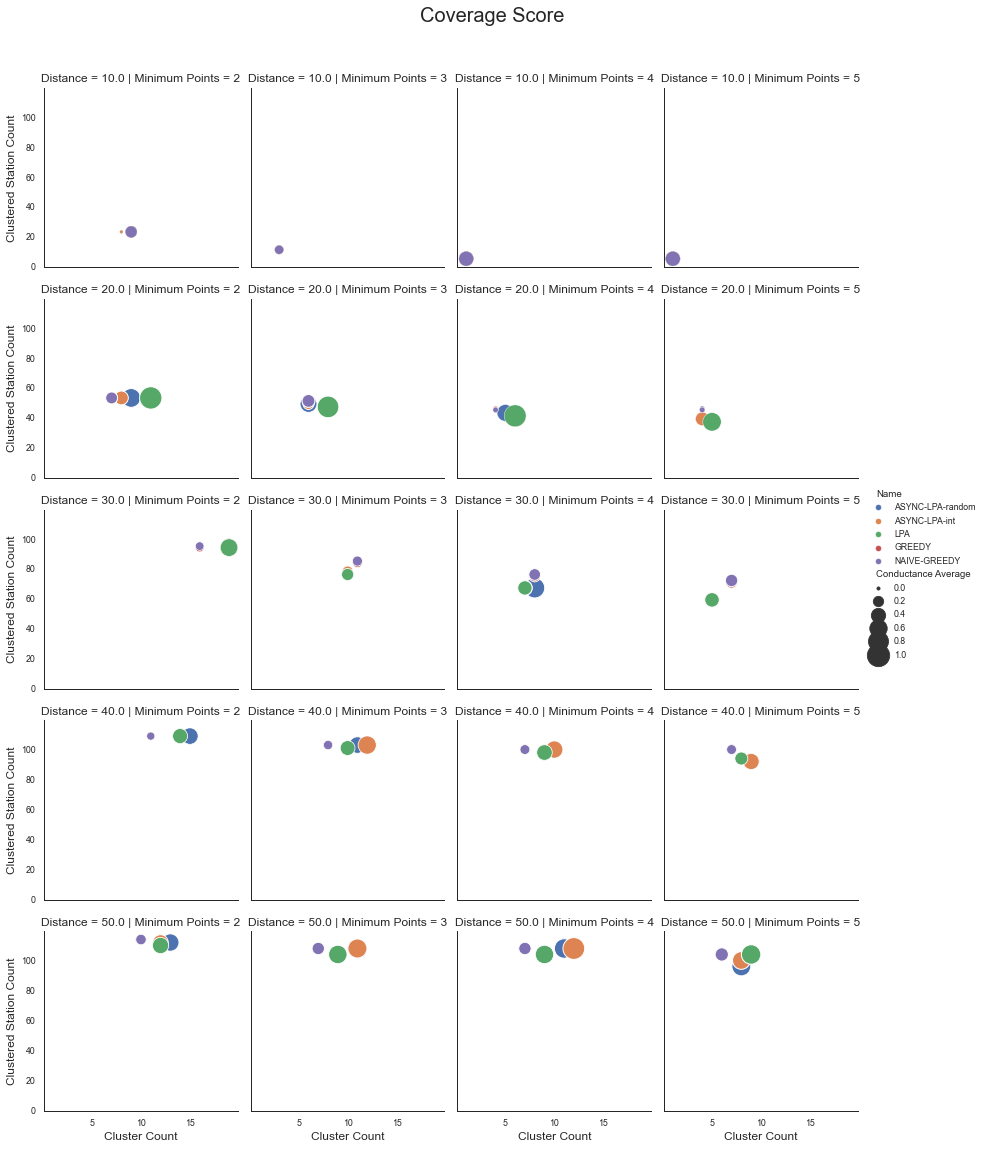

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#plot_qlty_msr_df=[graph_norm_df['Method','Cluster Count','Clustered Station Count',
#                          'Minimum Points','Distance','Davies Bouldin score']]
#plt.figure(figsize=(5,5))
plt.rcParams['figure.figsize']=(5,5)
#fig, g = plt.subplots(2, 2, figsize=(15,2*5), dpi=100, sharex=True, sharey=True)
sns.set_style("white")
sns.set_context("paper", rc={"font.size":12, "axes.labelsize":12}, font_scale=1.0)
g=sns.relplot(
    data=graph_norm_df,
    row='Distance', 
    col='Minimum Points',
    x="Cluster Count", y="Clustered Station Count",
    hue="Name", size="Conductance Average",
    palette='deep', sizes=(10, 500),
    height=3.0
)

plt.suptitle('Coverage Score',y=1.05, size=20)
#g.fig.legend(markerscale=1.2)
plt.savefig('../images/outputs/graph_cluster_Relational_Plot.png', bbox_inches='tight')
plt.show()